In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For reproducible results.
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [2]:
LABEL = "direction_numeric"

N_TIME_STEPS = 260
N_LABELS = 3

Xtrain = pd.read_csv('stock-train.csv')
Xvalid = pd.read_csv('stock-valid.csv')

ytrain = Xtrain.pop(LABEL)
yvalid  = Xvalid.pop(LABEL)

ytrain_categorical = to_categorical(ytrain.values)
yvalid_categorical = to_categorical(yvalid.values)

print(f"Shape of Xtrain: {Xtrain.shape}")
print(f"Shape of y: {yvalid_categorical.shape}\n")

print(Xtrain.head(1))
print(ytrain_categorical[0])

Shape of Xtrain: (11164, 260)
Shape of y: (2394, 3)

      day_0     day_1     day_2     day_3     day_4     day_5     day_6  \
0 -0.144946 -0.135877 -0.146586 -0.149944 -0.151658 -0.149648 -0.150216   

      day_7     day_8     day_9  ...   day_250   day_251   day_252   day_253  \
0 -0.151742 -0.135856 -0.127655  ... -0.175549 -0.175757 -0.164736 -0.172003   

    day_254   day_255   day_256   day_257   day_258   day_259  
0 -0.183098 -0.192609 -0.185822 -0.213345 -0.216334 -0.217794  

[1 rows x 260 columns]
[0. 0. 1.]


To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [3]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

## Baseline

If we simply start assigning the most common class to every record in validation data, what is the accuracy?

In [4]:
sum(yvalid == ytrain.value_counts().idxmax()) / yvalid.shape[0]

0.29490392648287383

## Linear Model

Single Layer Network

**Note:** 
 - Training the model without a regularizer results in a frantic change of loss and accuracy in every epoch.
 - We keep the number of nodes in last Dense layer equal to number of classes, because it converts the output to a meaningful prediction probability for each class after applying softmax.

In [7]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Input(260,))
model.add(keras.layers.Dense(
    N_LABELS, 
    activation="softmax",
    kernel_regularizer=keras.regularizers.l1(l=0.1)))

print(f"Ouput Shape: {model.output_shape}\n")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
    )

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=30,
                    verbose=0)

model.summary()

Ouput Shape: (None, 3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 783       
                                                                 
Total params: 783
Trainable params: 783
Non-trainable params: 0
_________________________________________________________________


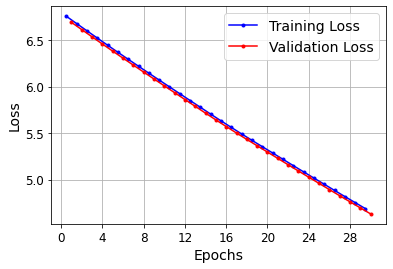

In [8]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

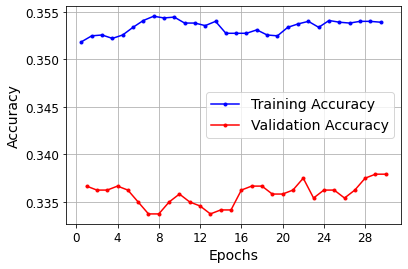

In [9]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

Report mean accuracy of last 5 epochs as result

In [10]:
np.mean(history.history['val_accuracy'][-5:])

0.33700918555259707

## Deep Neural Network

Multi-layer Dense Neural Network

In [11]:
keras.backend.clear_session()

dnn_hidden_units = [16, 8]

model = keras.models.Sequential()
model.add(keras.layers.Input(260,))

for unit in dnn_hidden_units:
    model.add(keras.layers.Dense(unit, activation="relu"))

model.add(keras.layers.Dense(
    N_LABELS, 
    activation="softmax",
    kernel_regularizer=keras.regularizers.l1(l=0.1)))

print(f"Ouput Shape: {model.output_shape}\n")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
    )

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=10,
                    verbose=0)

model.summary()

Ouput Shape: (None, 3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                4176      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 4,339
Trainable params: 4,339
Non-trainable params: 0
_________________________________________________________________


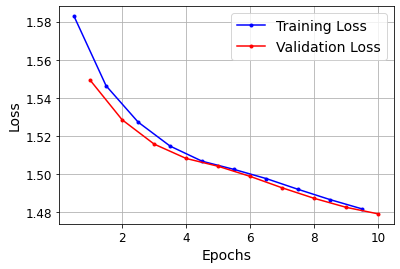

In [12]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

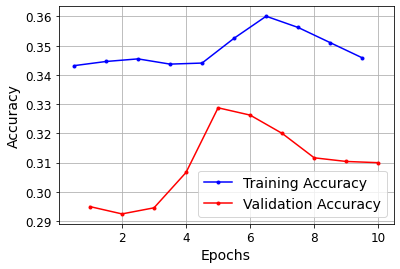

In [13]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [14]:
np.mean(history.history['val_accuracy'][-5:])

0.3156223952770233

## Convolutional Neural Network

1-D Convolutional layers are also used to aggregate over (extract features from) a time series. The rolling window aggregates over a single-dimension along time-stamps, i.e. W(t<sub>1</sub>, t<sub>2</sub>,..., t<sub>strides</sub>)

Conventionally, `MaxPooling` layers are used to downsample Conv layers output, usually by taking the maximum value over a spatial window.

We need to `Flatten` the results of MaxPool to get back data similar to original shape.

See also:
 - Ouput Shape of (4, 10, 128) - (batch_size, num_vectors, vector_size/number of input channels)
    - https://datascience.stackexchange.com/a/89784
    - https://stackoverflow.com/a/65010509
 - For complex shapes in CNN: [A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

In [15]:
# An example of Conv layer output shape

input_shape = (4, 10, 128) # (batch_size, num_vectors, vector_size)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(
    filters=32, 
    kernel_size=3,
    strides=1,
    activation='relu',
    padding="same",
    input_shape=input_shape[1:])(x)
print(y.shape)

(4, 10, 32)


In [16]:
# Let's checkout shape of our data at different stages

input_shape = (Xtrain.shape[0], Xtrain.shape[1])
a = tf.random.normal(input_shape)
print(f"Input Shape:{a.shape}")

# Keep single channel
b = keras.layers.Reshape(target_shape=[Xtrain.shape[1], 1])(a)
print(f"Single Channel Shape:{b.shape}")

c = tf.keras.layers.Conv1D(
    filters=5, 
    kernel_size=5,
    strides=2,
    activation='relu',
    padding="same",
    input_shape=input_shape)(b)
print(f"Conv1D Output Shape:{c.shape}")

d = keras.layers.MaxPooling1D(
    pool_size=2,
    strides=None,
    padding="valid"
    )(c)
print(f"MaxPooling1D Output Shape:{d.shape}")

# Revert to original shape
e = keras.layers.Flatten()(d)
print(f"Flatten Output Shape:{e.shape}")

Input Shape:(11164, 260)
Single Channel Shape:(11164, 260, 1)
Conv1D Output Shape:(11164, 130, 5)
MaxPooling1D Output Shape:(11164, 65, 5)
Flatten Output Shape:(11164, 325)


In [19]:
keras.backend.clear_session()

model = keras.models.Sequential()

# Single Channel Input
model.add(keras.layers.Reshape(target_shape=[Xtrain.shape[1], 1]))

# Conv layer
model.add(keras.layers.Conv1D(
    filters=5,
    kernel_size=5,
    strides=2,
    padding="valid", # no padding
    input_shape=(None, Xtrain.shape[0], Xtrain.shape[1])
))

model.add(keras.layers.MaxPooling1D(
    pool_size=2,
    strides=None,
    padding="valid"
))

# Flatten to original shape
model.add(keras.layers.Flatten())

# Dense layers for prediction
model.add(keras.layers.Dense(
    units=Xtrain.shape[1]//4,
    activation="relu"
))

model.add(keras.layers.Dense(
    N_LABELS, 
    activation="softmax",
    kernel_regularizer=keras.regularizers.l1(l=0.1)))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
    )

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=10,
                    verbose=0)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 260, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 128, 5)            30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 5)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 65)                20865     
                                                                 
 dense_1 (Dense)             (None, 3)                 198       
                                                        

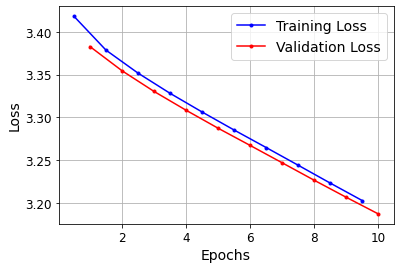

In [20]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

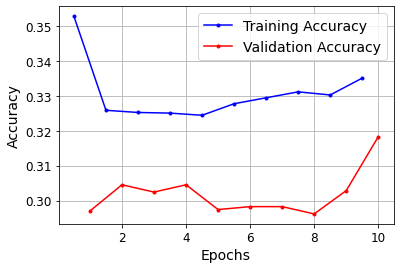

In [21]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [22]:
np.mean(history.history['val_accuracy'][-5:])

0.30275689363479613

## 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=46e3e238-14db-4736-bba3-428176481d68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>